# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### The way the question is written I'm not sure if you want the number of unique articles a user views, the total number of interactions they make, or both.

#### Let's find the number of unique articles viewed by each user

In [3]:
unique_counts = df.groupby('email')['article_id'].nunique()

In [4]:
unique_counts.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    12
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     5
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [5]:
unique_counts.value_counts().sort_index()

1      1557
2       752
3       524
4       374
5       282
6       246
7       177
8       138
9       109
10      114
11       80
12       75
13       67
14       69
15       47
16       35
17       47
18       45
19       38
20       27
21       19
22       22
23       17
24       19
25       25
26       15
27       20
28       10
29       21
30       15
       ... 
44        5
45        6
46        5
47        1
48        2
49        3
50        1
51        2
52        7
53        1
54        2
55        1
56        2
57        3
58        6
59        2
60        2
61        2
62        1
63        1
66        2
70        2
71        5
72        3
75        2
96        2
97        2
100       1
101       1
135       2
Name: article_id, Length: 73, dtype: int64

#### Let's plot this for ease of interpretation

(array([  4.56400000e+03,   3.76000000e+02,   1.27000000e+02,
          3.90000000e+01,   2.20000000e+01,   1.20000000e+01,
          0.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   14.4,   27.8,   41.2,   54.6,   68. ,   81.4,   94.8,
         108.2,  121.6,  135. ]),
 <a list of 10 Patch objects>)

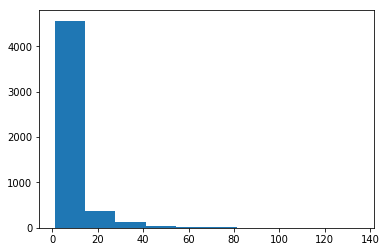

In [6]:
plt.hist(unique_counts)

#### Let's get the total number of interactions per user - including multiple interactions with the same article

In [7]:
counts = df.groupby('email')['article_id'].count()

In [8]:
counts.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

(array([  4.91500000e+03,   1.67000000e+02,   4.60000000e+01,
          1.10000000e+01,   7.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   37.3,   73.6,  109.9,  146.2,  182.5,  218.8,  255.1,
         291.4,  327.7,  364. ]),
 <a list of 10 Patch objects>)

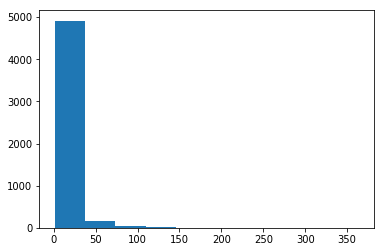

In [9]:
plt.hist(counts)

#### Now let's calculate the median and max. interactions

In [10]:
# To find the median number of articles per user
import statistics

In [11]:
average_articles = statistics.median(counts)

In [12]:
max_articles = counts.max()

In [13]:
# Fill in the median and maximum number of user_article interactions below

median_val = average_articles
max_views_by_user = max_articles

print('The median number of articles viewed per user is {}'.format(median_val))
print('The most articles viewed by a single user is {}'.format(max_views_by_user))

The median number of articles viewed per user is 3.0
The most articles viewed by a single user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find and explore duplicate articles

dups = df_content[df_content.duplicated(subset='article_id')]

In [15]:
dups

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [16]:
len(dups)

5

In [17]:
len(df_content)

1056

In [18]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

In [19]:
len(df_content)

1051

In [20]:
# What values does 'doc_status' take?

df_content['doc_status'].value_counts()


Live    1051
Name: doc_status, dtype: int64

#### As there is no variaion in 'doc_status', this doesn't really tell us anything

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [21]:
#a. The number of unique articles that have an interaction with a user.

unique_arts = df['article_id'].nunique() 

In [22]:
# let's make sure there are no articles without a user interacting with it

df.groupby('article_id')['email'].nunique().sort_values()

# OK, all articles are interacted with

article_id
1119.0      1
1266.0      1
1237.0      1
1233.0      1
974.0       1
984.0       1
1202.0      1
1200.0      1
724.0       1
961.0       1
1344.0      1
1072.0      1
1092.0      1
417.0       1
675.0       1
1113.0      1
653.0       1
662.0       1
1127.0      1
1075.0      2
1121.0      2
972.0       2
1251.0      2
1122.0      2
384.0       2
1235.0      2
1234.0      2
1091.0      2
1144.0      2
1230.0      2
         ... 
1305.0    216
1393.0    217
1293.0    225
1172.0    227
1432.0    232
1430.0    237
1276.0    238
1165.0    238
1162.0    245
1354.0    252
1185.0    255
1338.0    255
124.0     270
151.0     279
1170.0    279
1368.0    280
1436.0    282
1304.0    282
1336.0    284
1351.0    288
43.0      299
1160.0    299
1427.0    308
1271.0    314
1431.0    320
1398.0    329
1314.0    345
1364.0    388
1429.0    397
1330.0    467
Name: email, Length: 714, dtype: int64

In [23]:
#b. The number of unique articles in the dataset (whether they have any interactions or not).

#We need to look at the df_content data to get no. of articles on the IBM platform

all_arts_in_dataset = df_content['article_id'].nunique()

In [24]:
#c. The number of unique users in the dataset. (excluding null values)

individual_users = df['email'].nunique()  #Note that by default this doesn't include missing values

In [25]:
# d. The number of user-article interactions in the dataset.

In [26]:
total_interactions = df.groupby('email')['article_id'].count().sum()

In [27]:
total_interactions

45976

In [28]:
# However, this value wasn't accepted in the tests. Let's explore the missing values a bit

In [29]:
df['email'].isnull().sum()

17

In [30]:
df['article_id'].isnull().sum()

0

In [31]:
interactions_inc_missings = len(df)

In [32]:
# Turns out we need to include the 'missing' users too.

In [33]:
unique_articles = unique_arts # The number of unique articles that have at least one interaction
total_articles = all_arts_in_dataset # The number of unique articles on the IBM platform
unique_users = individual_users # The number of unique users
# The number of user-article interactions
user_article_interactions = interactions_inc_missings


print('The number of unique articles that have at least one interaction {}'.format(unique_articles))
print('The number of unique articles on the IBM platform is {}'.format(total_articles))
print('The number of unique users is {}'.format(unique_users))
print('The number of user-article interactions is {}'.format(user_article_interactions))


The number of unique articles that have at least one interaction 714
The number of unique articles on the IBM platform is 1051
The number of unique users is 5148
The number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [34]:
article_counts = df.groupby('article_id')['email'].count()

In [35]:
article_counts.sort_values()

article_id
1092.0      1
984.0       1
417.0       1
1237.0      1
1233.0      1
1202.0      1
1200.0      1
1266.0      1
1072.0      1
724.0       1
1113.0      1
1344.0      1
974.0       1
662.0       1
653.0       1
1119.0      1
675.0       1
1127.0      1
1244.0      2
1130.0      2
364.0       2
1251.0      2
1235.0      2
1135.0      2
1137.0      2
1230.0      2
1067.0      2
1227.0      2
1226.0      2
1210.0      2
         ... 
1052.0    330
1430.0    336
1432.0    340
1276.0    347
151.0     352
1172.0    363
1165.0    372
1336.0    379
1338.0    382
1305.0    413
1368.0    418
1354.0    426
1160.0    433
1185.0    442
1393.0    454
1351.0    457
43.0      460
1398.0    465
1271.0    473
1436.0    481
1304.0    483
1162.0    512
1170.0    565
1293.0    572
1314.0    614
1364.0    627
1427.0    643
1431.0    671
1330.0    927
1429.0    937
Name: email, Length: 714, dtype: int64

In [36]:
most_reads = article_counts.max()

In [37]:
max_count_article_id = str(article_counts.idxmax())

In [38]:
most_viewed_article_id = max_count_article_id  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_reads # The most viewed article in the dataset was viewed how many times?

print('The id of the most viewed article in the dataset is {}'.format(most_viewed_article_id))
print('This articles was viewed {} times'.format(max_views))

The id of the most viewed article in the dataset is 1429.0
This articles was viewed 937 times


In [39]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [40]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [41]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    article_frequency = df.groupby('title')['user_id'].count()
    article_ordered = article_frequency.sort_values(ascending=False)
    top_articles = article_ordered.index[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    id_frequency = df.groupby('article_id')['user_id'].count()
    id_ordered = id_frequency.sort_values(ascending=False)
    top_ids = id_ordered.index[:n]
 
    return top_ids # Return the top article ids

In [42]:
# Note to self - earlier snag was that I was returning value count, just needed series index (i.e. the titles)

In [43]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')


In [44]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [45]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    test_matrix = df.groupby(['user_id','article_id'])['title'].count().unstack()
    test_matrix = test_matrix.fillna(0)
    test_matrix[test_matrix >1] = 1
    user_item = test_matrix
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [46]:
user_item.head() # originally forgot to count by title, which caused problems later on

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [48]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered (list)
    
    '''
    #See the content based solutions bit of the course
    
    # compute similarity of each user to the provided user
    
    # find dot prod of each user with every other. Note we need to transpose to put user_id's on both axes
    user_x = user_item.loc[user_id]
    dot_prod_user = user_x.dot(np.transpose(user_item))
   
    # sort by similarity - can make list of index no's in the same line
    ordered_sim = dot_prod_user.sort_values(ascending=False).index.tolist()
    
    # remove the own user's id
    ordered_sim.remove(user_id)
    most_similar_users = ordered_sim 
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [49]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [50]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for article_id in article_ids:
        article_names.append(df[df['article_id'] == float(article_id)]['title'].values[0])
    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    row = user_item.loc[user_id]
    article_ids = row[row==1].index.astype(str).tolist()
    article_names = get_article_names(article_ids)  
    
    return article_ids, article_names 
   
   
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = np.array([])
  
    ids_seen, names_seen = get_user_articles(user_id)

    similar_users = find_similar_users(user_id)
  
    for user in similar_users:
        potential_ids, potential_recs = get_user_articles(user)
        new_recs = np.setdiff1d(potential_ids, ids_seen)
        
        if len(recs) + len(new_recs) <= m:
            recs= np.append(recs, new_recs)
        else:
            recs= np.append(recs, new_recs[:m - len(recs)])
            break
      
    return recs # return your recommendations for this user_id  

In [51]:
user_user_recs(1, 10)

array(['1000.0', '1014.0', '1025.0', '1051.0', '108.0', '1101.0', '1148.0',
       '1159.0', '1160.0', '1162.0'], 
      dtype='<U32')

In [52]:
# Check Results    
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [53]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [54]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) in the i
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    #Create dataframe
    neighbours_df = pd.DataFrame()
    
    #find similar users and similarity score
    
    # Note this is different to when we create the find_similar_users function  
    # as we are keeping the similarity score as well as the user id's
    user_x = user_item.loc[user_id]
    dot_prod_user = user_x.dot(np.transpose(user_item))
    ordered_sim = dot_prod_user.sort_values(ascending=False)#.drop(user_id)
    most_similar = ordered_sim 
    
    neighbours_df['user'] = most_similar.index
    neighbours_df['similarity_score'] = most_similar.values  #neighbours_df['similarity_score'] = most_similar.values
   
    interactions = df.groupby('user_id')['article_id'].count()
    interactions = interactions.fillna(0)
   
    neighbours_df = neighbours_df.merge(interactions.to_frame(), left_on='user', right_on='user_id')
    neighbours_df = neighbours_df[neighbours_df['user'] !=user_id] 
    # When I first ran this, the dataframe kept being returned with the interaction column named "article_id"
    neighbours_df = neighbours_df.rename(columns={"user": "user", "similarity_score": "similarity_score", "article_id": "interactions"})
    
    neighbours_df = neighbours_df.sort_values(['similarity_score', 'interactions'], ascending=False) 
     
    
    return neighbours_df # Return the dataframe specified in the doc_string


def frequency_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user, 
    but this time round they should be sorted by the number of interaction
    '''
    # Your code here 
    
    # get the relevant row
    row = user_item.loc[user_id] 
    # Take columns where there is value of 1 andconvert to list of strings
    article_ids = row[row==1].index.astype(str).tolist() 
    
    # Calculate number of interactions per article
    article_interactions = df.groupby('article_id').count()['user_id'] 
    
    # Sort the list of id's by the values of article_interactions. 
    article_ids = [x for _,x in sorted(zip(article_interactions, article_ids))]
    
    # Get the article names 
    article_names = get_article_names(article_ids)  
    
    return article_ids, article_names 

In [106]:
get_top_sorted_users(131)

,user,similarity_score,interactions
1,3870,74.0,144
2,3782,39.0,363
3,23,38.0,364
5,203,33.0,160
4,4459,33.0,158
6,98,29.0,170
7,3764,29.0,169
9,49,29.0,147
8,3697,29.0,145
10,242,25.0,148


In [55]:
def user_user_recs_part2(user_id, m=10):

 recs_to_add = []

 similar_users = get_top_sorted_users(user_id)
 similar_users = similar_users['user'] # not ethat tis doesn't include the user_id feed into the function

 article_interactions = df.groupby('article_id').count()['user_id']
 
 for x in similar_users.values:
        # List of article id values present in user, but not in input user_id
        a, b = get_user_articles(x)
        c, d = get_user_articles(user_id)
        
        if len(recs_to_add) <= m:
         new_recs = np.setdiff1d(a, c, assume_unique=True)
         recs_to_add.extend(new_recs)
        
        else:
            break
        
 new_list = [float(item) for item in recs_to_add]
 recs_to_add = article_interactions.loc[new_list].sort_values(ascending=False)#[:10]
 recs = recs_to_add.iloc[:m]  
 recs = recs.index
    
 rec_names = get_article_names(recs)

 return recs, rec_names

In [56]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
Float64Index([1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0,
              1354.0, 1368.0],
             dtype='float64', name='article_id')

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [57]:
#cells for workings

In [58]:
Similar_to_1 = find_similar_users(1)

In [59]:
Similar_to_1[0]

3933

In [60]:
Similar_to_131 = find_similar_users(131)

In [61]:
### Tests with a dictionary of results

user1_most_sim = Similar_to_1[0] 
user131_10th_sim = Similar_to_131[9] 

print('The user that is most similar to user 1 is user {}'.format(user1_most_sim))
print('The 10th most similar user to user 131 is user {}'.format(user131_10th_sim))

The user that is most similar to user 1 is user 3933
The 10th most similar user to user 131 is user 242


In [62]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**We know nothing about this user, so it is not possible to use similarity metrics to make recommendations based on similar users. This new user also has no history or ratings data that we could base recommendations on. In this case our best bet would be assume that this new user's tastes are similar to aggregate averages and to recommend the most popular titles.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [63]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [64]:
new_user_recs # these are rigcorrect, but notice that the numbers in the assert statement are strings

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')

In [65]:
new_list = [str(item) for item in new_user_recs]
    
new_user_recs = new_list

In [66]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [67]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [68]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [69]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [70]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [71]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [72]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, compute_uv=True) # use the built in to get the three matrices

In [73]:
u.shape

(5149, 5149)

In [74]:
s.shape

(714,)

In [75]:
vt.shape

(714, 714)

#### Let's compare the variance explained by the first 2 components to the findings from the class material.

In [76]:
total_var = np.sum(s**2)
var_exp_comp1_and_comp2 = s[0]**2 + s[1]**2
perc_exp = round(var_exp_comp1_and_comp2/total_var*100, 2)
print("The total variance in the original matrix is {}.".format(total_var))
print("Ther percentage of variability captured by the first two components is {}%.".format(perc_exp))

The total variance in the original matrix is 33681.99999999999.
Ther percentage of variability captured by the first two components is 10.7%.


**In many ways this is quite similar to what we saw in the lessons; we were able to calculate s, u and vt successfully, as our dataset doesn't have any missing values, the dimensions u reflect the number of users in our data while those of vt reflect the number of articles, and s only has data in one dimension at that this point.
However, the data set used here is one-hot encoded to show if a user has seen anrticles or not, whereas the data in the class contains ratings - giving it more variation. Possibly as consequence of this, in the data here only about 11% of variance is explained by the first 2 components, compared to 99.91% in the class material.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

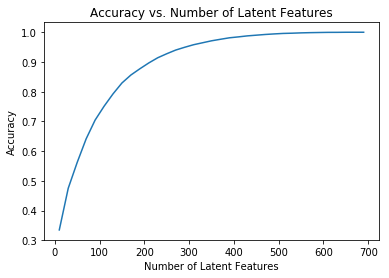

In [77]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [78]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [79]:
df_test.shape

(5993, 3)

In [80]:
df_test.nunique()

article_id    574
title         574
user_id       682
dtype: int64

In [81]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = df_train.groupby(['user_id','article_id'])['title'].count().unstack()
    user_item_train = user_item_train.fillna(0)
    user_item_train[user_item_train >1] = 1
    
    user_item_test = df_test.groupby(['user_id','article_id'])['title'].count().unstack()
    user_item_test = user_item_test.fillna(0)
    user_item_test[user_item_test >1] = 1
    
    test_idx = user_item_test.index.values   
    
    test_arts = user_item_test.columns.values   
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

#### How many users appear in both the train and test data / how many test users can we make predictions for?

In [82]:
train_users = user_item_train.index.values

In [83]:
users_overlap = np.intersect1d(test_idx, train_users)

In [84]:
len(users_overlap) # We have 20 users who appear in both the training and test data

20

In [85]:
users_overlap

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

In [86]:
users_overlap.shape

(20,)

#### How many users can't we make predictions for because of the cold-start problem?

In [87]:
(df_test['user_id'].nunique()) - len(users_overlap)

662

#### How many articles are in the test set and training set?

In [88]:
train_articles = np.array(user_item_train.columns)

In [89]:
articles_overlap = np.intersect1d(test_arts, train_articles)

In [90]:
len(articles_overlap) # All of the artices in the test set!

574

#### How many articles can't we make recommendations for because of the cold-start problem?

In [91]:
(df_test['article_id'].nunique()) - len(articles_overlap) # None!

0

In [92]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here,
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

#### To reshape u and vt correctly we need to find positions of users and articles that appear in both data sets

#### In order to do this we need quite a few pieces of data. So far we have: 
#### Users and articles in the training data:
- train_users 
- train_articles

#### Users and articles in the test data
- test_idx
- test_arts

#### Indices where these overlap
- users_overlap
- articles_overlap

#### Now we need to find the positions of overlapping rows and columns within the training data

In [93]:
train_ids = np.where(np.in1d(train_users, users_overlap))[0] # would have used isin but this IDE doesn't seem to support it

In [94]:
train_art_idx = np.where(np.in1d(train_articles, articles_overlap))[0] #note the [0] is key as it removes an unwanted dimension

#### Now we select the relevant id's for the test data

In [95]:
test_set_indices = np.where(np.in1d(test_idx, users_overlap))[0]

#### Finally, we can set indices in the test data to only contain the relevant rows. We will later reshape u and vt to reflect the relevant training data.

In [96]:
user_item_test = user_item_test.iloc[test_set_indices, :]

In [97]:
user_item_test.shape 

(20, 574)

In [98]:
user_item_train # Let's just check that the train_ids are in range

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
# Make sure to compare predicted and actual values

# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, compute_uv=True)

In [100]:
u_train.shape

(4487, 4487)

In [101]:
s_train.shape

(714,)

In [102]:
vt_train.shape

(714, 714)

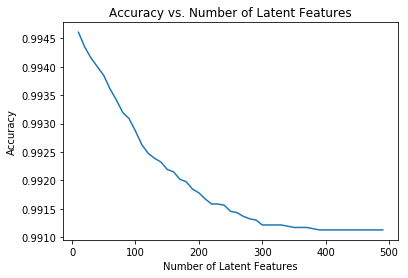

In [103]:
num_latent_feats = np.arange(10,500,10) # how many features can articles have?
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # the dimensions of s_new and vt_train need to match smaller number of users and articles in the test set
    
    u_new = u_new[train_ids, :]
    vt_new = vt_new[:, train_art_idx]
   
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    
    #Need to narrow this down to cases where there are overlapping users / articles
    #Look at how they reshape matrices in section 11 of the course
    
    diffs = np.subtract(user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# Don't necessarily need to plot    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**At a glance the results look good, with high accuracy across all numbers of latent variables, although it is worth noting that there are only 20 users that are present in both datasets, so the results will not the the most robust.** 

**In the example above we don't have a lot of information on our users. One way to determine if these recommendations are better than user's current ways of finding articles would be to introduce data on ratings. This would allow an A/B testing set-up, where we could compare the ratings that users give articles recommended by this system, compared to another system or a control group. We could potentially also look at metrics such as how often a user clicks on a recommended article or the total number of articles that a user reads - presumably if the recommendations are poor then a user won't keep reading for long, while those receiving good recommendations will engage with the platform for more actively.**

**Alternatively we could ask users directly, e.g. through a pop up that asks for general feedback or specifically asks what they thought of the recommendations. If users are asked to rate the recommendations - say from 0-10 - that could potentially make a neat metric for testing.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

## Acknowledgments

While working on this project I used Udacity GPT to help me trouble shoot various aspects of my code.

I also looked at work submitted by these previous students and used it to get a better idea of what certain tasks were asking for, to evaluate the results of my functions where there were no test cells, and to troubleshoot some code issues (e.g. what to use instead of np.isin):

- https://github.com/sergatron/recommendations_with_IBM/blob/master/Recommendations_with_IBM.ipynb
- https://github.com/nicovillena/recommendations-with-ibm/blob/master/Recommendations_with_IBM.ipynb
- https://github.com/louisteo9/recommendations-with-IBM/blob/main/Recommendations_with_IBM.ipynb

In [104]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0